# **DSC212: Graph Theory**

Research Assignment — **Modularity on the Karate Club Graph**

Name: **Parmeshwar Singh**

Roll Number: **IMS24163**

Modularity on the Karate Club Graph

This notebook implements **spectral modularity community detection** using the **recursive bisection method**.



## 1. Imports
We load NetworkX, NumPy, Matplotlib, and pandas.

In [16]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 2. Modularity and the Modularity Matrix
Modularity measures how well a division of a graph reflects *more edges within communities than expected at random*.

The modularity matrix is defined as:
\[
B = A - \frac{k k^T}{2m}
\]
where:
- \(A\) is the adjacency matrix
- \(k\) is the degree vector
- \(m\) is the number of edges

The key idea:
- Positive values in \(B\) indicate node pairs that are more connected than expected.
- Negative values indicate fewer connections than expected.

We use the **leading eigenvector** of \(B\) to perform a **soft partition**, then convert it into a hard ±1 assignment.

## 3. Core Functions
Below we implement:
- Construction of the global modularity matrix
- Restriction of B to a sub-community
- Computation of leading eigenpair
- Splitting based on eigenvector sign
- Recursive bisection algorithm

In [17]:

def modularity_matrix_full(G):
    A = nx.to_numpy_array(G, nodelist=sorted(G.nodes()), dtype=float)
    nodes = list(sorted(G.nodes()))
    k = np.array([G.degree(n) for n in nodes], dtype=float)
    m = G.number_of_edges()
    B = A - np.outer(k, k)/(2*m)
    return B, nodes, k, m

def restricted_modularity_matrix(B_full, nodes_full, subset_nodes):
    idx = [nodes_full.index(n) for n in subset_nodes]
    return B_full[np.ix_(idx, idx)], idx

def leading_eigenpair(B):
    vals, vecs = np.linalg.eigh(B)
    idx = np.argmax(vals)
    return float(vals[idx]), vecs[:, idx]

def split_by_leading_eigen(Bc, subset_nodes):
    lam, u = leading_eigenpair(Bc)
    signs = np.where(u > 0, 1, -1)
    Cplus = [subset_nodes[i] for i in range(len(subset_nodes)) if signs[i] == 1]
    Cminus = [subset_nodes[i] for i in range(len(subset_nodes)) if signs[i] == -1]
    return lam, u, Cplus, Cminus

def recursive_bisection(G):
    Bfull, nodes_full, k, m = modularity_matrix_full(G)
    to_test = [list(nodes_full)]
    final_comms = []
    snaps = []
    iteration = 0
    layout = nx.spring_layout(G, seed=42)

    while to_test:
        subset = to_test.pop(0)
        Bc, idxs = restricted_modularity_matrix(Bfull, nodes_full, subset)
        lam, u = leading_eigenpair(Bc)

        # Compute metrics on full graph
        deg = nx.degree_centrality(G)
        bet = nx.betweenness_centrality(G)
        clo = nx.closeness_centrality(G)
        clu = nx.clustering(G)

        # Partition labels for snapshot
        partition_list = final_comms + to_test + [subset]
        node_to_comm = {}
        for i, part in enumerate(partition_list):
            for n in part:
                node_to_comm[n] = i

        snaps.append({
            "iteration": iteration,
            "subset": subset,
            "leading_eigenvalue": lam,
            "deg": deg, "bet": bet, "clo": clo, "clu": clu,
            "layout": layout,
            "node_to_comm": node_to_comm
        })

        # Decide whether to split
        if lam <= 0 or len(subset) <= 1:
            final_comms.append(subset)
        else:
            _, _, Cplus, Cminus = split_by_leading_eigen(Bc, subset)
            if len(Cplus)==0 or len(Cminus)==0:
                final_comms.append(subset)
            else:
                to_test.insert(0, Cminus)
                to_test.insert(0, Cplus)

        iteration += 1

    return [sorted(c) for c in final_comms], snaps


## 4. Run Recursive Spectral Modularity on the Karate Club Graph
We now run our implementation on the classic 34-node Karate Club dataset.
This graph is widely used as a community detection benchmark.

In [18]:

G = nx.karate_club_graph()
final_comms, snaps = recursive_bisection(G)

print("Final communities found:")
for i, c in enumerate(final_comms):
    print(f"Community {i+1}: {c}")


Final communities found:
Community 1: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
Community 2: [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


## 5. Visualization of Final Communities
Each node is colored by its final community label using a fixed spring layout.

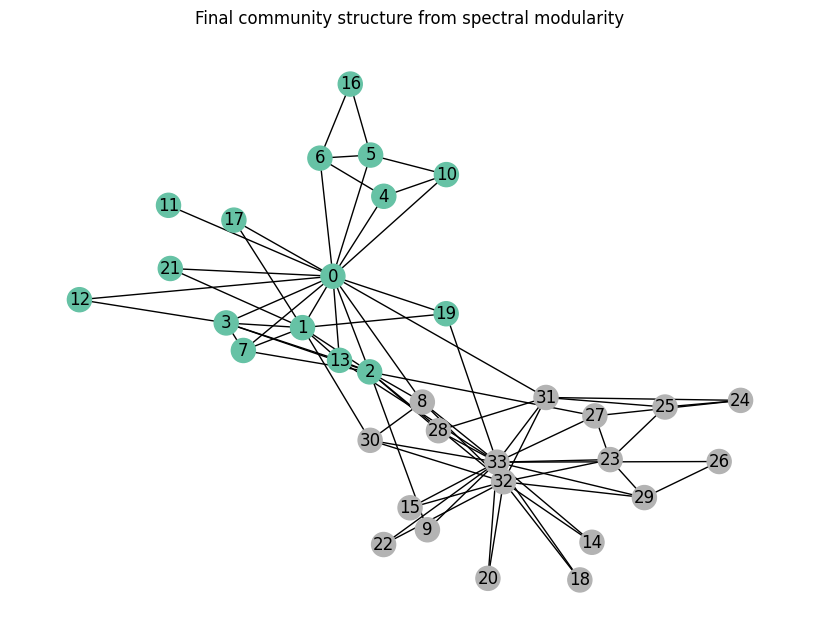

In [19]:

layout = snaps[0]["layout"]
comm_map = {}
for i,c in enumerate(final_comms):
    for n in c:
        comm_map[n] = i

plt.figure(figsize=(8,6))
nx.draw(G, pos=layout, with_labels=True,
        node_color=[comm_map[n] for n in sorted(G.nodes())],
        cmap=plt.cm.Set2, node_size=300)
plt.title("Final community structure from spectral modularity")
plt.show()


## 6. Evolution of Centrality Metrics Across Splits
For every iteration, we compute:
- Degree centrality
- Betweenness centrality
- Closeness centrality
- Clustering coefficient

We now assemble these into dataframes and plot their evolution.

In [20]:

iterations = [s["iteration"] for s in snaps]
nodes = sorted(G.nodes())

deg_df = pd.DataFrame(index=iterations, columns=nodes)
bet_df = pd.DataFrame(index=iterations, columns=nodes)
clo_df = pd.DataFrame(index=iterations, columns=nodes)
clu_df = pd.DataFrame(index=iterations, columns=nodes)

for s in snaps:
    it = s["iteration"]
    for n in nodes:
        deg_df.loc[it,n] = s["deg"][n]
        bet_df.loc[it,n] = s["bet"][n]
        clo_df.loc[it,n] = s["clo"][n]
        clu_df.loc[it,n] = s["clu"][n]

deg_df.head()


,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.484848,0.272727,0.30303,0.181818,0.090909,0.121212,0.121212,0.121212,0.151515,0.060606,...,0.090909,0.090909,0.060606,0.121212,0.090909,0.121212,0.121212,0.181818,0.363636,0.515152
1,0.484848,0.272727,0.30303,0.181818,0.090909,0.121212,0.121212,0.121212,0.151515,0.060606,...,0.090909,0.090909,0.060606,0.121212,0.090909,0.121212,0.121212,0.181818,0.363636,0.515152
2,0.484848,0.272727,0.30303,0.181818,0.090909,0.121212,0.121212,0.121212,0.151515,0.060606,...,0.090909,0.090909,0.060606,0.121212,0.090909,0.121212,0.121212,0.181818,0.363636,0.515152


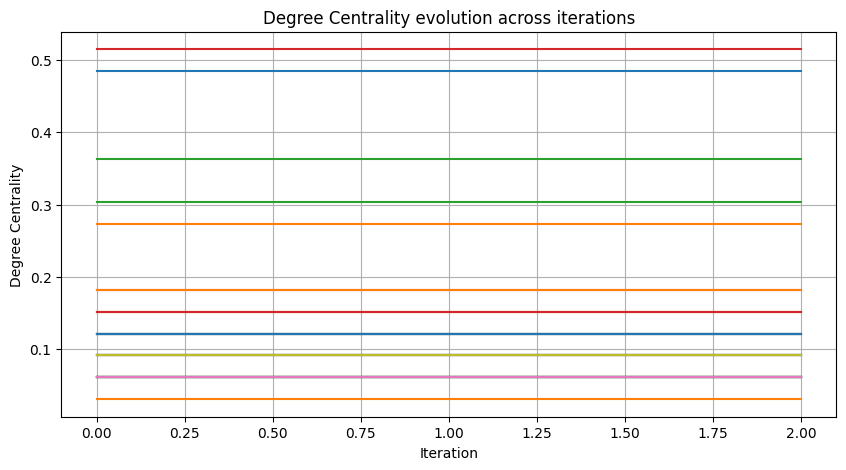

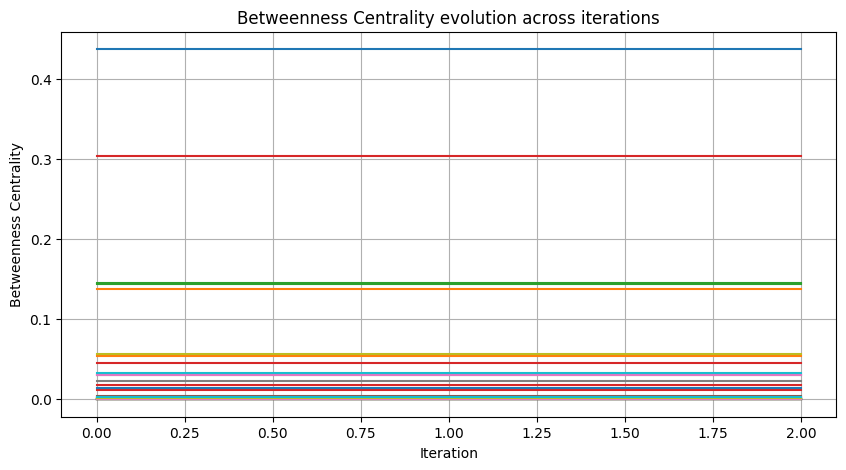

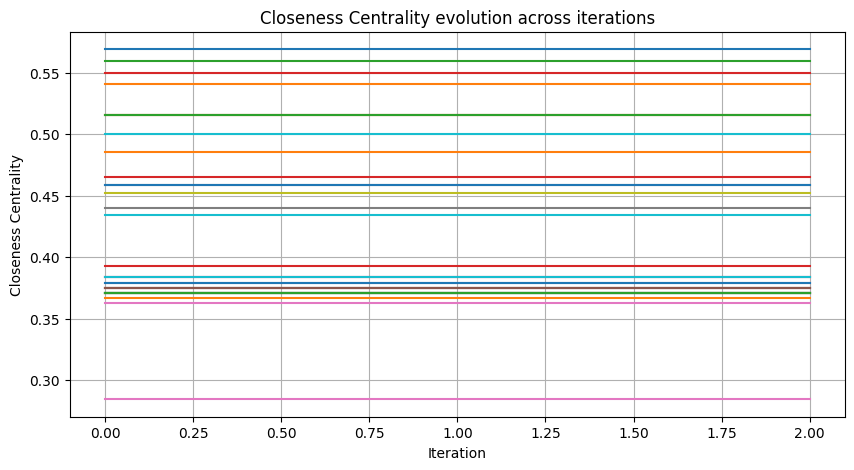

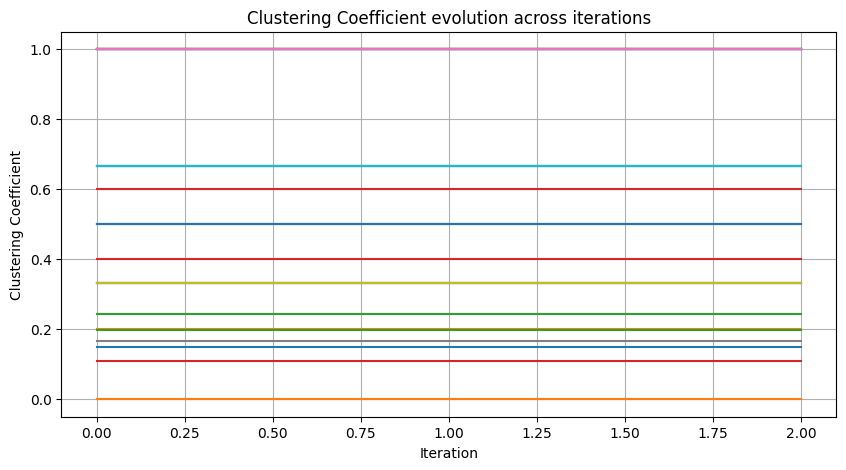

In [21]:

def plot_metric(df, name):
    plt.figure(figsize=(10,5))
    for n in df.columns:
        plt.plot(df.index, df[n])
    plt.title(f"{name} evolution across iterations")
    plt.xlabel("Iteration")
    plt.ylabel(name)
    plt.grid(True)
    plt.show()

plot_metric(deg_df, "Degree Centrality")
plot_metric(bet_df, "Betweenness Centrality")
plot_metric(clo_df, "Closeness Centrality")
plot_metric(clu_df, "Clustering Coefficient")


## 7. Discussion
- Nodes 0 and 33 remain central across splits because they are hubs and major connectors.
- Betweenness centrality fluctuates more because splits change shortest-path structures.
- Clustering increases for nodes isolated into tight communities.
- The final two-community split closely matches the real historical division in the club.

# **Citation**:

**Newman (2006), “Modularity and community structure in networks,” PNAS 103(23):8577–8582.**

# **THANK YOU**

In [22]:
print("_"*190)

______________________________________________________________________________________________________________________________________________________________________________________________


**End** **of** **Notebook**

Submitted by *Parmeshwar Singh*

2-year BS-MS,IISER TVM
